In [187]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [188]:

def parse_data_new() -> list:
    file_name = '../data/names_new.csv'
    with open(file_name, 'r') as f:
        data = f.read().splitlines()
    return [d.split(',')[0] for d in data]

def setup_data(data) -> tuple:
    clean_data = []
    valid_chars = 'âabcçdefgğhıiîjklmnoöprsştuüûvyz'
    for name in data:
        name = name.replace('İ', 'i') # Capital İ is two chars in ascii
        if all([c in valid_chars for c in name.lower()]):
            clean_data.append(name.lower())
    new_data = clean_data

    itos = {i+1:c for i, c in enumerate(valid_chars)}
    itos[0] = '.' # start and end token
    stoi = {c:i for i, c in itos.items()}

    return new_data, itos, stoi

data, itos, stoi = setup_data(parse_data_new())

# Trial-Error / Going with the video

In [3]:
block_size = 3
xs, ys = [], [] 
for word in data:
    context = [0] * block_size
    for ch in word + '.':
        idx = stoi[ch]
        xs.append(context)
        ys.append(idx)
        # print(''.join(itos[i] for i in context), '-->', itos[idx])
        context = context[1:] + [idx]
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [ ]:
C = torch.randn((len(stoi), 2)) # 2D

In [ ]:
C[5] # weights for idx 5

In [ ]:
F.one_hot(torch.tensor(5), num_classes=len(stoi)).float() @ C # weights for idx 5 retrieved with one hot representation

In [ ]:
xs[5], C[xs[5]]

In [ ]:
C[xs][0] # Weights for data point xs[0]
xs[0].float() @ C[xs][0] # multiplying inputs with corresponding weights


In [ ]:
emb = C[xs]
emb.shape

In [ ]:
# Constructing hidden layer
num_hidden_neurons = 100
W1 = torch.randn((emb.shape[1] * emb.shape[2], num_hidden_neurons)) # 3x2 = 6
b1 = torch.randn(num_hidden_neurons)

In [ ]:
# inefficient methods for plucking the embeddings to make it shaped (x, 6)
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape
torch.cat(torch.unbind(emb, 1), 1).shape

In [ ]:
# Calculating the hidden layer actv
h = torch.tanh(emb.view(-1, emb.shape[1] * emb.shape[2]) @ W1 + b1)
h

In [ ]:
# Output layer Weights and biases
W2 = torch.randn((num_hidden_neurons, len(stoi)))
b2 = torch.randn(len(stoi))

In [ ]:
logits = h @ W2 + b2
logits.shape

In [ ]:
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdims=True)

In [ ]:
probs.shape

In [ ]:
pred = probs[torch.arange(len(xs)), ys]

# Clean version

In [191]:
# Hyper-parameters here
block_size = 5
num_dimensions = 10
num_hidden_neurons = 300
num_epochs = 200000
minibatch_size = 128

In [192]:
def build_dataset(words, block_size=3):
    xs, ys = [], [] 
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            idx = stoi[ch]
            xs.append(context)
            ys.append(idx)
            # print(''.join(itos[i] for i in context), '-->', itos[idx])
            context = context[1:] + [idx]
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys

import random
random.shuffle(data)
n1 = int(0.8 * len(data))
n2 = int(0.9 * len(data))
x_train, y_train = build_dataset(data[:n1],block_size)
x_val, y_val = build_dataset(data[n1:n2],block_size)
x_test, y_test = build_dataset(data[n2:],block_size)

In [193]:
# Cleaned version
g = torch.Generator().manual_seed(2147483647)

# Setting up parameters
C = torch.randn((len(stoi), num_dimensions), generator=g)
    
W1 = torch.randn((num_dimensions * block_size, num_hidden_neurons), generator=g)
b1 = torch.randn(num_hidden_neurons, generator=g)

W2 = torch.randn((num_hidden_neurons, len(stoi)), generator=g)
b2 = torch.randn(len(stoi), generator=g)

parameters = [C, W1, b1, W2, b2]

In [194]:
# Total number of parameters
sum(p.nelement() for p in parameters)

25563

In [195]:
for p in parameters:
    p.requires_grad = True

In [196]:
# Determining step size
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

# Examining learning rate
lri = []
loss_i = []
step_i = []


In [197]:
# Why minibatch is better:
#   Its better to use approximate gradient and take more steps
#   than to take less steps towards exact gradient

for e in range(num_epochs): 

    # Getting minibatches
    idx = torch.randint(0, x_train.shape[0], (minibatch_size,))

    # Forward pass
    emb = C[x_train[idx]]
    h = torch.tanh(emb.view(-1, emb.shape[1] * emb.shape[2]) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[idx])
    print(f"Epoch {e}:\t{loss.item()}", end='\r')

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    # lr = lrs[e]
    lr = 0.1 if e < num_epochs / 2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Stat track for lr
    # lri.append(lre[e]) 
    loss_i.append(loss.log10().item())
    step_i.append(e)

Final Loss 2.0069475173950195175


In [198]:
# Train loss of all the data
emb = C[x_train]
h = torch.tanh(emb.view(-1, emb.shape[1] * emb.shape[2]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
print(f"Train Loss {loss}")

Train Loss 2.0069475173950195


In [199]:
emb = C[x_val]
h = torch.tanh(emb.view(-1, emb.shape[1] * emb.shape[2]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_val)
print(f"Validation Loss {loss}")

Validation Loss 2.1850221157073975


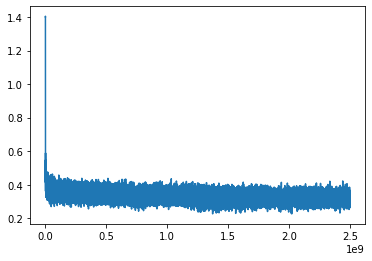

In [183]:
plt.plot(step_i[1:], loss_i)

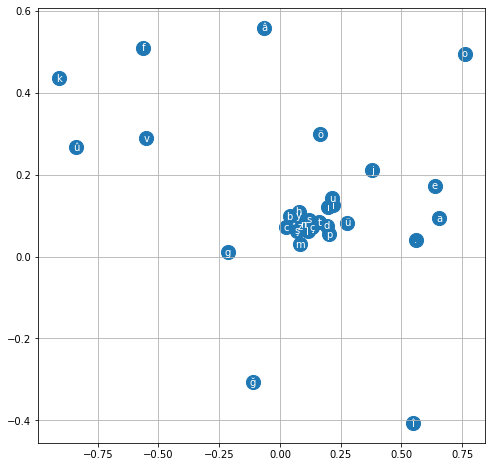

In [133]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

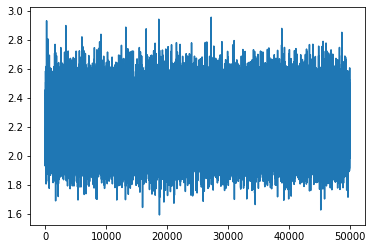

In [113]:
plt.plot(step_i, loss_i)

In [204]:
# Sampling from the model
num_samples = 20
for _ in range(num_samples):
    out = ''
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, 1).item()
        context = context[1:] + [idx]
        if idx == 0:
            break
        out += itos[idx]
    print(out)

sener
samime
ayralıle
racin
tubimtil
adın
kızacin
erksan
akyse
dimeddin
fehinati
limat
haşhent
azat
züallâ
mihzi
mührezana
meyşunur
bahrugümay
ferizkin
